In [1]:
import pandas, numpy

In [2]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'font.family':'sans-serif', 
                            'xtick.labelsize':16, 
                            'ytick.labelsize':16, 
                            'figure.figsize':(16*(2/3), 9*(2/3)), 
                            'axes.labelsize':20
                           })

In [3]:
results_dir = '/Users/adrian/research/akureyri/results/sleuth_pipeline/'
tpm_file = '/Users/adrian/research/akureyri/results/deseq2_pipeline/DESeq2_TPM_values.tsv'
counts_file = '/Users/adrian/research/akureyri/results/sleuth_pipeline/sleuth_scaled_reads_bygene.csv'
metadata_file = '/Users/adrian/research/akureyri/results/deseq2_pipeline/metadata.tsv'
annotation_file = '/Users/adrian/research/akureyri/results/deseq2_pipeline/annotation.tsv'

tpm_threshold = 2

# read info

In [4]:
metadata = pandas.read_csv(metadata_file, sep='\t')
metadata.head()

,sample,label,time,culture,path
1,test01,RNA_test_1_EKRN230071387-1A,two,2D,/Users/adrian/research/akureyri/results/kallis...
3,test02,RNA_test_2_EKRN230071388-1A,two,3D,/Users/adrian/research/akureyri/results/kallis...
5,test03,RNA_test_3_EKRN230071389-1A,fourteen,2D,/Users/adrian/research/akureyri/results/kallis...
7,test04,RNA_test_4_EKRN230071390-1A,fourteen,3D,/Users/adrian/research/akureyri/results/kallis...
9,test05,RNA_test_5_EKRN230071391-1A,two,2D,/Users/adrian/research/akureyri/results/kallis...


In [5]:
tpm = pandas.read_csv(tpm_file, sep='\t', index_col=0)
tpm.head()

,test01,test02,test03,test04,test05,test06,test07,test08,test09,test10,test11,test12
ENSG00000000003,12.480951,14.500356,12.973101,13.639502,13.056435,15.536032,13.025809,11.380208,14.604471,16.337347,14.475374,13.477217
ENSG00000000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000000419,120.981242,107.924893,120.233355,105.070478,117.550878,101.073762,123.991231,93.626046,123.207637,97.723357,93.615215,112.974659
ENSG00000000457,3.624791,5.523426,3.872989,3.323551,2.324639,5.041956,4.175279,4.372463,4.307249,5.125585,4.414247,4.047019
ENSG00000000460,15.407117,10.366913,12.076084,17.697199,11.087450,8.450714,11.056973,21.588369,17.890017,9.149726,18.332927,18.389641


In [6]:
counts = pandas.read_csv(counts_file, sep='\t', index_col=0)
counts.head()

,test01,test02,test03,test04,test05,test06,test07,test08,test09,test10,test11,test12
ENSG00000000003,678.791432,681.307742,803.568534,685.429129,816.856258,710.076498,702.851933,548.873872,742.745362,764.101705,748.354304,656.643982
ENSG00000000005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000000419,3044.550721,2347.637018,3428.945961,2442.411910,3417.377571,2141.176937,3098.125112,2158.319618,2932.901829,2141.571141,2282.428412,2594.505554
ENSG00000000457,245.640061,323.341843,299.170783,208.122067,181.089037,287.056176,280.682694,261.297709,272.412792,298.062511,283.427388,244.913462
ENSG00000000460,942.896829,548.083002,842.104219,1000.774721,780.245054,434.552463,671.301519,1167.944258,1022.674986,480.956658,1064.543719,1006.420956


In [7]:
annotation = pandas.read_csv(annotation_file, sep='\t')
annotation.head()

,Unnamed: 0,ensembl_transcript_id,ensembl_gene_id,external_gene_name,gene_biotype,description
0,1,ENST00000387314,ENSG00000210049,MT-TF,Mt_tRNA,mitochondrially encoded tRNA-Phe (UUU/C) [Sour...
1,2,ENST00000389680,ENSG00000211459,MT-RNR1,Mt_rRNA,mitochondrially encoded 12S rRNA [Source:HGNC ...
2,3,ENST00000387342,ENSG00000210077,MT-TV,Mt_tRNA,mitochondrially encoded tRNA-Val (GUN) [Source...
3,4,ENST00000387347,ENSG00000210082,MT-RNR2,Mt_rRNA,mitochondrially encoded 16S rRNA [Source:HGNC ...
4,5,ENST00000386347,ENSG00000209082,MT-TL1,Mt_tRNA,mitochondrially encoded tRNA-Leu (UUA/G) 1 [So...


# contrasts


effect_time_2D.tsv	culture	2D	time	True
(143, 6)
(17087, 6)
(17230, 1)
    sample                        label      time culture  \
5   test03  RNA_test_3_EKRN230071389-1A  fourteen      2D   
11  test07  RNA_test_7_EKRN230071393-1A  fourteen      2D   
6   test11  RNA_test_3_EKRN240003677-1A  fourteen      2D   
1   test01  RNA_test_1_EKRN230071387-1A       two      2D   
9   test05  RNA_test_5_EKRN230071391-1A       two      2D   
2   test09  RNA_test_1_EKRN240003675-1A       two      2D   

                                                 path  
5   /Users/adrian/research/akureyri/results/kallis...  
11  /Users/adrian/research/akureyri/results/kallis...  
6   /Users/adrian/research/akureyri/results/kallis...  
1   /Users/adrian/research/akureyri/results/kallis...  
9   /Users/adrian/research/akureyri/results/kallis...  
2   /Users/adrian/research/akureyri/results/kallis...  
                      test03       test07       test11       test01  \
ENSG00000000003   803.568534   702.85

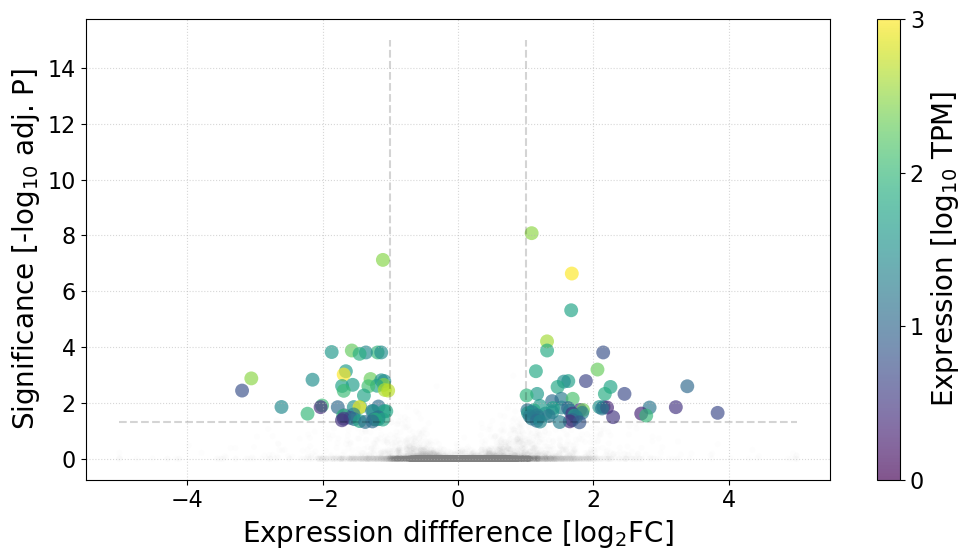

info stored in table

effect_time_3D.tsv	culture	3D	time	True
(1751, 6)
(15915, 6)
(17666, 1)
    sample                        label      time culture  \
7   test04  RNA_test_4_EKRN230071390-1A  fourteen      3D   
12  test08  RNA_test_8_EKRN230071394-1A  fourteen      3D   
8   test12  RNA_test_4_EKRN240003678-1A  fourteen      3D   
3   test02  RNA_test_2_EKRN230071388-1A       two      3D   
10  test06  RNA_test_6_EKRN230071392-1A       two      3D   
4   test10  RNA_test_2_EKRN240003676-1A       two      3D   

                                                 path  
7   /Users/adrian/research/akureyri/results/kallis...  
12  /Users/adrian/research/akureyri/results/kallis...  
8   /Users/adrian/research/akureyri/results/kallis...  
3   /Users/adrian/research/akureyri/results/kallis...  
10  /Users/adrian/research/akureyri/results/kallis...  
4   /Users/adrian/research/akureyri/results/kallis...  
                      test04       test08       test12       test02  \
ENSG00000000003

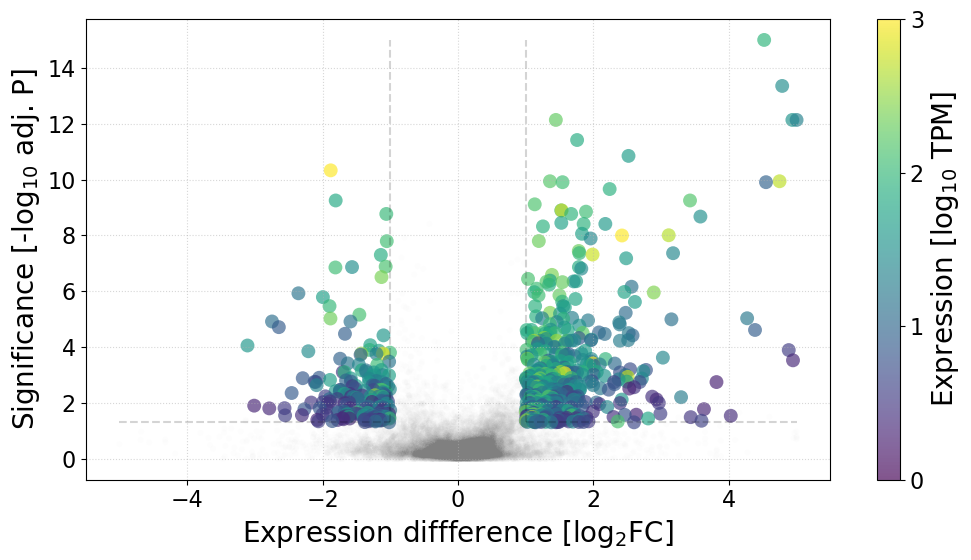

info stored in table

effect_culture_day2.tsv	time	two	culture	
(4291, 6)
(13193, 6)
(17484, 1)
    sample                        label time culture  \
3   test02  RNA_test_2_EKRN230071388-1A  two      3D   
10  test06  RNA_test_6_EKRN230071392-1A  two      3D   
4   test10  RNA_test_2_EKRN240003676-1A  two      3D   
1   test01  RNA_test_1_EKRN230071387-1A  two      2D   
9   test05  RNA_test_5_EKRN230071391-1A  two      2D   
2   test09  RNA_test_1_EKRN240003675-1A  two      2D   

                                                 path  
3   /Users/adrian/research/akureyri/results/kallis...  
10  /Users/adrian/research/akureyri/results/kallis...  
4   /Users/adrian/research/akureyri/results/kallis...  
1   /Users/adrian/research/akureyri/results/kallis...  
9   /Users/adrian/research/akureyri/results/kallis...  
2   /Users/adrian/research/akureyri/results/kallis...  
                      test02       test06       test10       test01  \
ENSG00000000003   681.307742   710.076498   764.

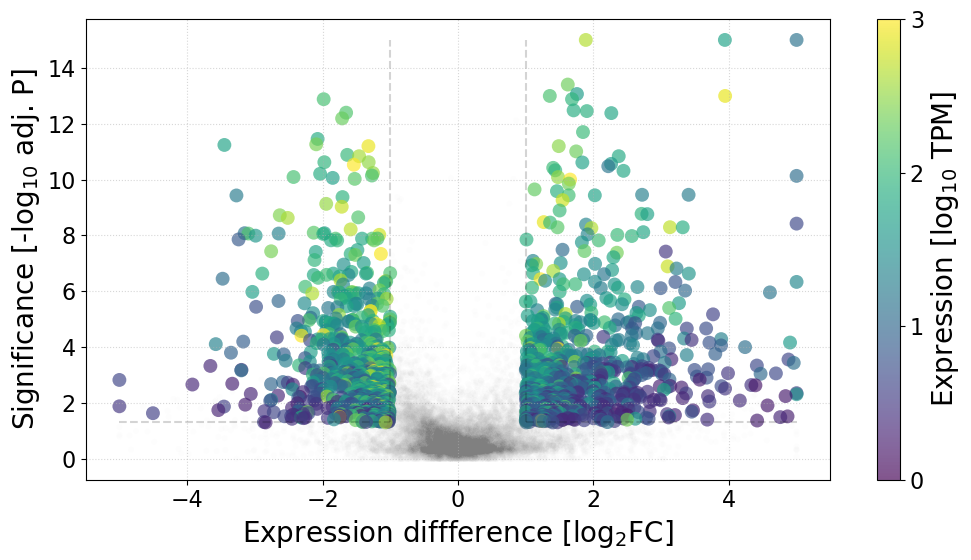

info stored in table

effect_culture_day14.tsv	time	fourteen	culture	
(647, 6)
(16882, 6)
(17529, 1)
    sample                        label      time culture  \
7   test04  RNA_test_4_EKRN230071390-1A  fourteen      3D   
12  test08  RNA_test_8_EKRN230071394-1A  fourteen      3D   
8   test12  RNA_test_4_EKRN240003678-1A  fourteen      3D   
5   test03  RNA_test_3_EKRN230071389-1A  fourteen      2D   
11  test07  RNA_test_7_EKRN230071393-1A  fourteen      2D   
6   test11  RNA_test_3_EKRN240003677-1A  fourteen      2D   

                                                 path  
7   /Users/adrian/research/akureyri/results/kallis...  
12  /Users/adrian/research/akureyri/results/kallis...  
8   /Users/adrian/research/akureyri/results/kallis...  
5   /Users/adrian/research/akureyri/results/kallis...  
11  /Users/adrian/research/akureyri/results/kallis...  
6   /Users/adrian/research/akureyri/results/kallis...  
                      test04       test08       test12       test03  \
ENSG0000

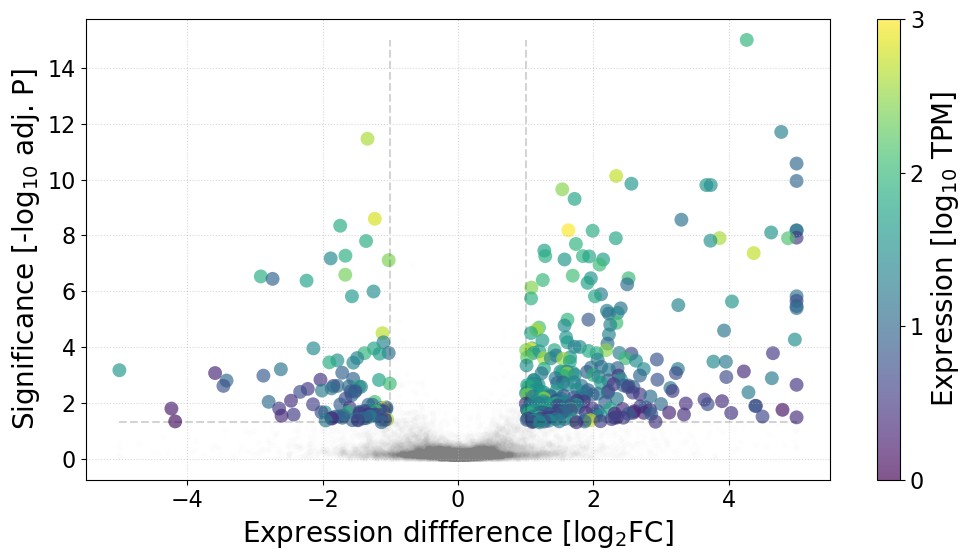

info stored in table
CPU times: user 1min 8s, sys: 139 ms, total: 1min 8s
Wall time: 1min 10s


In [8]:
%%time

def volcano_plotter(contrast):
    
    input_file_name = contrast[0]
    sorting_label_1 = contrast[1]
    sorting_label_2 = contrast[2]
    sorting_label_3 = contrast[3]
    sorting_label_4 = contrast[4]
    
    # define Q
    input_file = results_dir + input_file_name
    df = pandas.read_csv(input_file, sep='\t', index_col=1)
    print(df.shape)
    input_file_name = input_file_name.replace('.tsv', '.anti.tsv')
    input_file = results_dir + input_file_name
    anti = pandas.read_csv(input_file, sep='\t', index_col=1)
    print(anti.shape)
    pdf = pandas.concat([df, anti])
    pdf.drop(pdf.columns[:5], axis=1, inplace=True)
    print(pdf.shape)
    pdf.head()

    # define fold change on est. counts
    sub = metadata[metadata[sorting_label_1] == sorting_label_2]
    sub = sub.sort_values(sorting_label_3, ascending=bool(sorting_label_4))
    print(sub)
    labels = sub['sample']
    subset_counts = counts[labels]
    print(subset_counts.head())
    a = subset_counts.iloc[:, :3].median(axis=1)
    b = subset_counts.iloc[:, 3:].median(axis=1)
    c = numpy.log2(a + 1) - numpy.log2(b + 1)
    pdf['log2fc'] = c
    pdf.head()

    # define max group tpm and median tpm
    subset_tpm = tpm[labels]
            
    a = subset_tpm.iloc[:, :3].median(axis=1)
    b = subset_tpm.iloc[:, 3:].median(axis=1)
    c = subset_tpm.median(axis=1)
    
    df = pandas.DataFrame(a, columns=['median sample'])
    df['median reference'] = b 
    df['max median'] = df.max(axis=1)
    df['median'] = c
    print(df.head())
    
    pdf['max median'] = df['max median']
    pdf['median'] = df['median']
    print(pdf.shape)
    pdf

    # plot
    rules = (pdf['qval'] < 0.05) & (numpy.abs(pdf['log2fc']) > 1) & (pdf['max median'] > 2)
    big_dots = pdf[rules].index
    print(len(big_dots))
    small_dots = pdf.index[pdf.index.isin(big_dots) == False]
    
    x = pdf.loc[big_dots, 'log2fc']
    y = -numpy.log10(pdf.loc[big_dots, 'qval'])
    z = numpy.log10(pdf.loc[big_dots, 'median'] + 1)
    
    str_x = ['{:.4f}'.format(element) for element in x]
    str_y = ['{:.2e}'.format(10**(-element)) for element in y]
    str_z = ['{:.2f}'.format(10**(element)) for element in z]
    srt_qr = ['{:.3f}'.format(numpy.sqrt(a**2 + b**2 + c**2)) for a, b, c in zip(x, y, z)]
    
    x = numpy.clip(x, -5, 5)
    y = numpy.clip(y, 0, 15)
    matplotlib.pyplot.scatter(x, y, s=100, c=z, cmap='viridis', 
                              vmin=0, vmax=3, alpha=2/3, edgecolors='none')
    matplotlib.pyplot.colorbar(ticks=[0, 1, 2, 3], label='Expression [log$_{10}$ TPM]')
    
    x = pdf.loc[small_dots, 'log2fc']
    y = -numpy.log10(pdf.loc[small_dots, 'qval'])
    x = numpy.clip(x, -5, 5)
    y = numpy.clip(y, 0, 15)
    matplotlib.pyplot.scatter(x, y, color='gray', s=20, alpha=0.01, edgecolors='none')
    
    matplotlib.pyplot.plot([-1, -1], [-numpy.log10(0.05), 15], ls='--', color='black', alpha=1/6)
    matplotlib.pyplot.plot([1, 1], [-numpy.log10(0.05), 15], ls='--', color='black', alpha=1/6)
    matplotlib.pyplot.plot([-5, -1], [-numpy.log10(0.05), -numpy.log10(0.05)], ls='--', color='black', alpha=1/6)
    matplotlib.pyplot.plot([1, 5], [-numpy.log10(0.05), -numpy.log10(0.05)], ls='--', color='black', alpha=1/6)
    
    matplotlib.pyplot.xlabel('Expression diffference [log$_2$FC]')
    matplotlib.pyplot.ylabel('Significance [-log$_{10}$ adj. P]')
    
    matplotlib.pyplot.grid(ls=':', alpha=0.5)
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    matplotlib.pyplot.close()

    # store csv with responding genes
    storing_file = results_dir + input_file_name.replace('.anti.tsv', '.formatted_results.tsv')
    f = open(storing_file, 'w')
    f.write('ENSEMBL\tGene name\tBiotype\tDescription\tContrast median expression [TPM]\tExpression difference [log2 FC; ref=xx]\tSignificance [-log10 adj. P]\tQuantitative relevance\n')
    for i in range(len(big_dots)):
    
        ensembl = big_dots[i]
    
        gene_name = annotation[annotation['ensembl_gene_id'] == ensembl]['external_gene_name'].values[0]
        if isinstance(gene_name, str) == False:
            gene_name = 'not_found'
    
        biotype = annotation[annotation['ensembl_gene_id'] == ensembl]['gene_biotype'].values[0]
        try:
            description = annotation[annotation['ensembl_gene_id'] == ensembl]['description'].values[0].split(' [')[0]
        except:
            description = annotation[annotation['ensembl_gene_id'] == ensembl]['description'].values[0]
        if isinstance(description, str) == False:
            description = 'not_found'
            
        info = [ensembl, gene_name, biotype, description, str_z[i], str_x[i], str_y[i], srt_qr[i]]
        #print(info)
        info_string = '\t'.join(info) 
        f.write('{}\n'.format(info_string))
    f.close()
    print('info stored in table')

    return None

contrasts = [['effect_time_2D.tsv', 'culture', '2D', 'time', 'True'], 
             ['effect_time_3D.tsv', 'culture', '3D', 'time', 'True'],
             ['effect_culture_day2.tsv', 'time', 'two', 'culture', ''],
             ['effect_culture_day14.tsv', 'time', 'fourteen', 'culture', '']
            ]

for contrast in contrasts:
    print()
    print("\t".join(contrast))
    volcano_plotter(contrast)